In [1]:
import numpy as np
import pandas as pd
import cProfile
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GroupKFold, train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import time
from scipy.stats import pearsonr

from split import prep_data_before_train, random_split, subset

data = pd.read_feather("../data/processed/tarsusBV.feather")

X, y, ringnrs, mean_pheno = prep_data_before_train(data, "tarsus")
display(X["hatchisland"].unique())  
del data
X.drop(columns = ["hatchisland"], inplace = True)
X["ringnr"] = ringnrs   

target = pd.DataFrame(y)
target["mean_pheno"] = mean_pheno
target["ringnr"] = ringnrs

folds = random_split("tarsus", num_folds=10, seed=42)

X = pd.merge(X,folds, on = "ringnr", how = "inner") 
X = pd.merge(X,target, on = "ringnr", how = "inner")



array([ 28,  26,  38,  27,  24,  30,  20, 331,  21, 332,  29,  36,  22,
        23,  34,  35])

In [2]:
pearsonr(X["ID"], X["mean_pheno"])

PearsonRResult(statistic=0.9875179965386741, pvalue=0.0)

In [3]:
def run_xgb(X_train, y_train, X_val, y_val):
    xgb_params = {
        "objective": "reg:pseudohubererror", 
    }

    model = xgb.XGBRegressor(**xgb_params)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr

def run_lgb(X_train, y_train, X_val, y_val):
    lgb_params = {
        "objective": "huber",
        "alpha": 1.0   
    }

    model = lgb.LGBMRegressor(**lgb_params)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr 

def run_cb(X_train, y_train, X_val, y_val):
    cb_params = {
        "loss_function": "Huber:delta=1"
    }

    model = cb.CatBoostRegressor(**cb_params, verbose = 0)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr

# Using KFold cross-validation
def cross_val_run(model_fn, X_data, y_data):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_corrs = []

    for train_idx, val_idx in kf.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        corr = model_fn(X_train, y_train, X_val, y_val)
        fold_corrs.append(corr)

    return fold_corrs


In [4]:
#subset_sizes = [20, 50, 100, 200, 300, 500, 2000, 5000, 10000, 20000, 25000]
#subset_sizes = np.arange(1000, 27000, 2500)
subset_sizes = [10,20,30,50,90,160,280,500,900,1500,2600,4700,8200,14300,25000]
#do it for logscale as well

xgb_corr = []
lgb_corr = []
cb_corr = []

for size in subset_sizes:
    print(size)
    X_sub = subset(X, num_snps=size)
    print(X_sub.shape)

    X_data = X_sub.drop(columns=["ringnr", "ID", "fold", "mean_pheno"])
    y_data = X_sub[["ID", "mean_pheno"]]

    # Run 5-fold CV for each model and store results
    xgb_corr.append(cross_val_run(run_xgb, X_data, y_data))
    lgb_corr.append(cross_val_run(run_lgb, X_data, y_data))
    cb_corr.append(cross_val_run(run_cb, X_data, y_data))

    print("XGB correlations: ", xgb_corr)
    print("LGB correlations: ", lgb_corr)
    print("CB correlations: ", cb_corr)

10
(1915, 14)
XGB correlations:  [[-0.009320113794487345, 0.07996351187785997, -0.09429268615424302, 0.003678741211841516, 0.09633218846689093, -0.08574138564401637, -0.07089329819621851, -0.011040508174272504, -0.14307379251502478, 0.002034793755917174]]
LGB correlations:  [[0.04786592617394913, 0.11505749262761572, -0.05091743508688653, 0.06732439500337006, 0.09583139779258647, -0.02511831734358536, -0.0022609220127085524, 0.03546172619034674, -0.0879059676122194, -0.022100386806964686]]
CB correlations:  [[-0.013976538461271289, 0.10586555903955078, -0.07535831670094065, 0.036671459009367934, 0.09762390297889945, -0.03426713081426812, -0.054778435252198845, 0.015085721795820224, -0.11688066795577488, -0.026385758224890556]]
20
(1915, 24)
XGB correlations:  [[-0.009320113794487345, 0.07996351187785997, -0.09429268615424302, 0.003678741211841516, 0.09633218846689093, -0.08574138564401637, -0.07089329819621851, -0.011040508174272504, -0.14307379251502478, 0.002034793755917174], [0.1579

### Plots

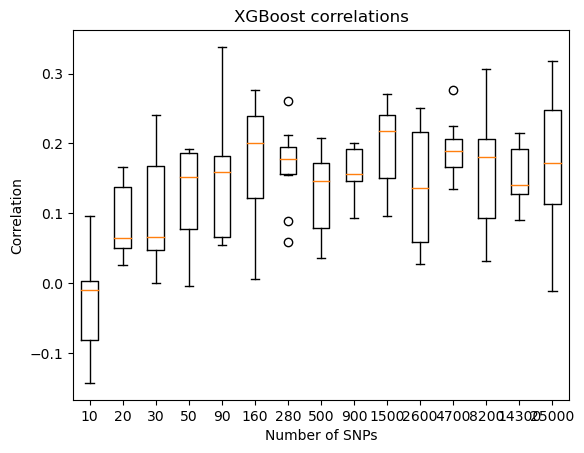

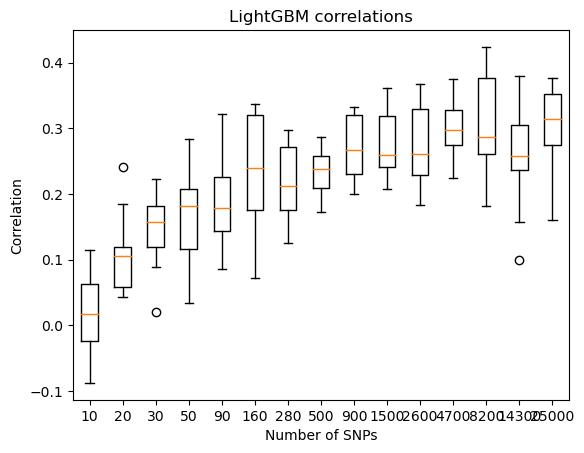

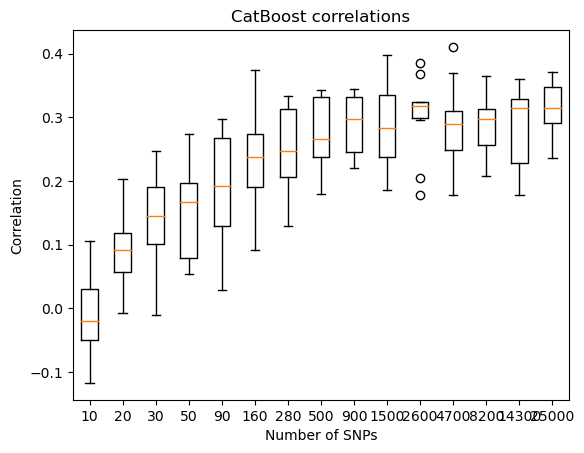

In [5]:
#plot results as boxplots
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(xgb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("XGBoost correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

plt.figure()
plt.boxplot(lgb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("LightGBM correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

plt.figure()
plt.boxplot(cb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("CatBoost correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

In [6]:
# Save results to file for later use
np.save("../data/results/xgb_corr_log_tarsus.npy", xgb_corr)
np.save("../data/results/lgb_corr_log_tarsus.npy", lgb_corr)
np.save("../data/results/cb_corr_log_tarsus.npy", cb_corr)